# COMP 3359 Artificial Intelligent Application Group One
## Reimplementation of Neural Style Transfer Methods and Evaluation

### 1.The purpose of this notebook
This notebook presents the code for one out of three methods we implement on neural style transfer, namely the **image-based optimization methods** .

In this notebook, we shall explain:
1. The overview of the neural style transfer method adopted by Gaty in the [paper](https://arxiv.org/abs/1508.06576) "A Neural Algorithm of Artistic Style" (2015)
2. The code we write based on this paper with detailed explanation and technical detail

---------------------------

### 2. Overview of this model
The idea underlying is basically to optimize the pixels in an image followed by a well-derived loss function which reflects the relative difference in content between new optimized images and relative style differences between style images, with the aid of a well trained descriptive network, in which case we adopt VGG 19 here. As this VGG 19 descriptive network is pretrained on image recognition tasks on ImageNet dataset, we expect its intermediate layers contain rich content and style information of the input images.

The loss function is composted of the weighted sum of the content weight, style weight and total variation weight,denoted by below formula.
By changing the appropriate hyperparameter, we can modify the importance of content loss and style loss, thus generate images with more styled or more realistic to content images.
<center><img src='./notebookimages/1.jpg' width='80%'/></center>

The content loss compute the differences in pixel value of the content image and the optimized image with preservation of spatial information, which is the sum of square 2-norm of the pixel wise difference of feature maps extracted from L layer of descriptive network,given by the below formula. G is the generated optimized images, C is the content images while S means style images.
<center><img src='./notebookimages/2.png' width='50%'/></center>

The style loss is given by the sum of the difference in gram matrix between style images and content images across multiple layers. The gram matrix denoted by 'G' in the formula is the the inner product among the channels in one particular feature maps, which measures the correlation between different features in one feature maps, hence, measure the style of an images. Thus, by minimizing the square difference between the gram matrix value of generated images and style images, we can make the generated images close to the style imaged in terms of the style. 
<left><img src='./notebookimages/3.png' width='40%'/></left> <right><img src='./notebookimages/4.png' width='20%'/></right>

The total variation loss term is an extra regularization term in the loss function, which penelize the loss function when there are too many higher frequency artifacts or checkboard noise within the function. It is actually a edge detector which detects the appearance of edges, that is , sharp changes in pixel value in the images. Qualitatively speaking, an increase in the total variation loss weight could remove the rough texture of the image and the resultant image looks much smoother. 
<left><img src='./notebookimages/5.png' width='40%'/></left>

As we keep on updatting the pixel value of the generated optimized images with this loss function, we could eventually obtain an images which is both similar to content images interms of the content and with the similar style as style images.

---------------------------

### 3. Implementation code
We first import necessary library. All of our implementations are based on tensorflow implementation. 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import datetime
import time

The Hyperparameter are given below. 
Several empty arrays are initilized to keep tracking of the noise through out of the training.

In [2]:
### Hyper parameter
NOISE_RATIO = 0.7
CONTENT_LAYERS = ['block5_conv1']
STYLE_LAYERS = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
STYLE_WEIGHT = [0.30,0.10,0.15,0.15,0.30]

EPOCH = 1
STEP = 300 

#Adam optimizer
LR = 0.5# 
EPSILON = 1e-1 # 
BETA = 0.99

CONTENT_WEIGHTS = 1e4
STYLE_WEIGHTS = 10
VARIATION_WEIGHTS = 100

IMAGE_NUM = 4

# Training loss track
STYLE_LOSS_P = [[],[],[],[],[]]
CONTENT_LOSS = []
STYLE_LOSS = []
TOTAL_LOSS = []
VARIATION_LOSS = []

We first build our neural network, which is basically an VGG-16 network pretrained on ImageNet. While instead of outputting the final prediction result, we extracts the feature maps of intermediate layers. The specific layers extracted is already given in the hyper parameter section. Notice that the weight of VGG network is not updated in this model, instead, it is the pixel value of the images which gets finally updated during the training process. 

Below is a graph of VGG 19 network, notice that the top full connection layer is removed as we do not need prediction result of the images.
The name of retrived feature map layers are exactly the same as those in hyper parameter section.
<center><img src='./notebookimages/6.png' width='50%'/></center>

In [3]:
class NRTmodel(tf.keras.models.Model):
    def __init__(self):
        super(NRTmodel, self).__init__()
        self.vgg = build_vgg()
        self.vgg.trainable = False   # Weight is not updated HERE

    def __call__(self, inputs):
        outputs = self.vgg(inputs)
        style_outputs, content_outputs = (outputs[:len(STYLE_LAYERS)], 
                                      outputs[len(STYLE_LAYERS):])
        
        content_collection = {}
        for i,value in enumerate(content_outputs):
            content_collection[CONTENT_LAYERS[i]] = value
        
        style_collection = {}
        for i,value in enumerate(style_outputs):
            style_collection[STYLE_LAYERS[i]] = value
    
        return {'content':content_collection, 'style':style_collection}
    

def build_vgg():
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False
        outputs = [vgg.get_layer(name).output for name in STYLE_LAYERS]+ [vgg.get_layer(name).output for name in CONTENT_LAYERS]
        model = tf.keras.Model([vgg.input], outputs)
        return model

We first load the images to tensor. Notice that the loaded images are float 3 channel tensor with range [0,1].
For the generative optimized images, we initialize it using weight sum of content images and gaussian noise images, composition adjusted by the NOISE_RATIO hyperparameter. When NOISE_RATIO is big, the initilized images are more of gaussain noise images, which takes longer steps to optimize while when the NOISE_RATIO is small, the initialized image are closed to content images, which may results in the generated images are too close to the content images and lack of variety.

In [4]:
def load_image():
    import os 
    curr_dir = "./"
    content_dir = os.path.join(curr_dir,"images","contents","") #./images/content/ 
    style_dir = os.path.join(curr_dir,"images","style","") 

    # Get image paths in data_dir
    content_data_paths = os.listdir(content_dir) 
    content_data_paths_full = [ os.path.join(content_dir, p) for p in content_data_paths]

    style_data_paths = os.listdir(style_dir) 
    style_data_paths_full = [ os.path.join(style_dir, p) for p in style_data_paths ]


    # As the number of data is lower, so we do not really need image generator
    content_batch = []
    for path in content_data_paths_full :
        if 'checkpoints' not in path:
            image_tensor = tf.keras.preprocessing.image.load_img(path, target_size=(224,224),interpolation='nearest')
            image_tensor = tf.keras.preprocessing.image.img_to_array(image_tensor,dtype = "float32")  #convert img form to tensor form
            content_batch.append(image_tensor)

    content_batch = np.array(content_batch)   
    content_image = content_batch.reshape((IMAGE_NUM,224,224,3))
   

    style_batch = []
    for path in style_data_paths_full :
        if 'checkpoints' not in path:
            image_tensor = tf.keras.preprocessing.image.load_img(path,target_size=(224,224),interpolation='nearest')
            image_tensor = tf.keras.preprocessing.image.img_to_array(image_tensor,dtype = "float32")  #convert img form to tensor form
            style_batch.append(image_tensor)
    style_batch = np.array(style_batch)   # Convert the list of tensor to one big tensor 
    style_image = style_batch.reshape((IMAGE_NUM,224,224,3)) # reshape the tensor to desire shape

    #Generates a noisy image by adding random noise to the content_image
    noise_image = np.random.uniform(0, 255, (IMAGE_NUM, 224, 224, 3)).astype('float32')
    noise_image = noise_image*NOISE_RATIO+content_image*(1-NOISE_RATIO)
                                        
    return content_image, style_image, noise_image

Here we visualize the content images, style images and noise images with different noise ratio

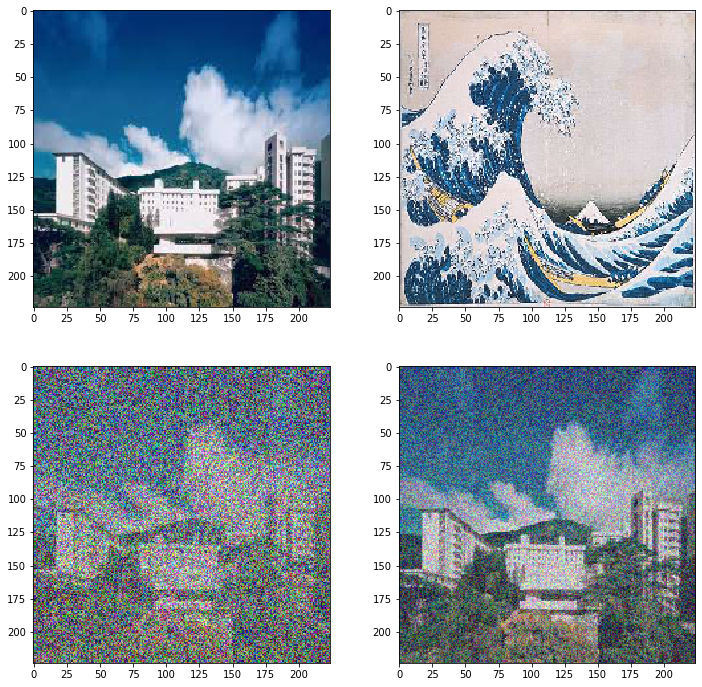

In [5]:
content_image, style_image, noise_image = load_image()
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(tf.cast(content_image[0],tf.int16))
fig.add_subplot(rows, columns, 2)
plt.imshow(tf.cast(style_image[0],tf.int16))
fig.add_subplot(rows, columns, 3)
plt.imshow(tf.cast(noise_image[0],tf.int16))

NOISE_RATIO = 0.4
content_image, style_image, noise_image = load_image()
fig.add_subplot(rows, columns, 4)
plt.imshow(tf.cast(noise_image[0],tf.int16))
plt.show()

We then compute the loss function according to the formulae given above. Notice that instead of adding the total loss of batches of images, we calculate the loss for each individual images in the batch. Since we perform image optimization on updatting pixel values on individual images, and individual images update is clearly more logical.

The calculation of content loss and total variation loss are straight forward according to the formula, while for the style loss, we need to unrolled the images tensor, representitng the batch of feature map from a particular layers, from the shape (B,H,W,C) to the shape (B,H*W,C). Then we calculate the gram matrix of these batches of images, with respect to this layer. This is esentially the matrix mupliplication of such tensor with its transpose, as illustared in the below figure.
<center><img src='./notebookimages/7.png' width='50%'/></center>

Furthermore, the total style weight is calculated as the weighted sum of the style weight in each particular layers. The total loss is the weighted sum of each component loss.

In [6]:
def calculate_loss(outputs,target_content,target_style,image):
    # unpack the content and style
    output_content = outputs["content"]
    output_style = outputs["style"]
    
    #Calculate content loss
    zeros = [0]*IMAGE_NUM
    content_loss = tf.constant(zeros, shape=[IMAGE_NUM, 1],dtype= 'float32')
    content_loss = tf.math.add_n([tf.reduce_mean((tf.reshape(target_content[name],[IMAGE_NUM,-1]) - tf.reshape(output_content[name],[IMAGE_NUM,-1]))**2,keepdims = True,axis = 1)  
                                      for name in output_content.keys()])
    content_loss *= (CONTENT_WEIGHTS / len(CONTENT_LAYERS))
    CONTENT_LOSS.append(content_loss[0][0])
    
    
    
    #Calculate the style loss
    style_loss = tf.constant(zeros, shape=[IMAGE_NUM, 1],dtype= 'float32')
    for i,name in enumerate(STYLE_LAYERS):
        m,H ,W, C = output_style[name].get_shape().as_list()
        unrolled_target_style = tf.reshape(target_style[name],[m,-1,C])
        gram_target = tf.matmul(unrolled_target_style, unrolled_target_style, transpose_a=True)/tf.cast(H*W, tf.float32)

        unrolled_output_style = tf.reshape(output_style[name],[m,-1,C])
        gram_output = tf.matmul(unrolled_output_style, unrolled_output_style, transpose_a=True)/tf.cast(H*W, tf.float32)
        style_loss_layer = tf.reduce_mean((tf.reshape(gram_target,[IMAGE_NUM,-1]) - tf.reshape(gram_output,[IMAGE_NUM,-1]))**2,keepdims = True,axis = 1)
        STYLE_LOSS_P[i].append(style_loss_layer)
        style_loss += (style_loss_layer*STYLE_WEIGHT[i])
                
    style_loss *= STYLE_WEIGHTS 
    STYLE_LOSS.append(style_loss[0][0])
    
    
    # Total variation loss
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    variation_loss = (tf.reduce_mean(tf.reshape(x_var,[IMAGE_NUM,-1])**2,keepdims = True,axis = 1) + tf.reduce_mean(tf.reshape(y_var,[IMAGE_NUM,-1])**2,keepdims = True,axis = 1)) * VARIATION_WEIGHTS
    VARIATION_LOSS.append(variation_loss[0][0])
    
    
    total_loss = tf.add_n([content_loss,style_loss,variation_loss])
    return total_loss

Then, we could combine the loss function and network defined above to produce the function which train the network by one step.

We use **tf.GradientTape** to record the feed forward passes through the network. It works like computing a recording of the feed forward pass through the model, and finally playing it backwards, in order to perform back propagation. This gradient tape records all the gradients happening through the network, and finally enables us to apply the training rule to update the current value of the parameters using these gradients by **apply_gradients** function.

Since the pixel value would on be valid within the range [0,255], thus we need to clip the image pixel within this range.

In [7]:
def train_one_step(image_tensor,target_content,target_style):
    image = tf.Variable(image_tensor,dtype = 'float32')
    with tf.GradientTape() as tape:
        outputs = backbone_Net(image)
        loss = calculate_loss(outputs,target_content,target_style,image)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255))
    return image

We then instantiate the network and optimizer, load the image and start our training!

In [8]:
#instantiate the model and optimizer
backbone_Net = NRTmodel()
optimizer = tf.optimizers.Adam(learning_rate=LR)

#load the image
content_tensor, style_tensor, result_tensor= load_image()

#define the VGG model and then specify the target_content and target_style used
target_content = backbone_Net(content_tensor)["content"]
target_style = backbone_Net(style_tensor)["style"]

#record the start time
start_time = time.time()
# train the result tensor picture
for n in range(EPOCH):
    for m in range(STEP):
        result_tensor = train_one_step(result_tensor,target_content,target_style)
    # We store image to jpg file each epoch
    for i in range(IMAGE_NUM):
        store_tensor = tf.cast(result_tensor,tf.int16)
        store_tensor = tf.cast(store_tensor,tf.uint8)
        img = tf.io.encode_jpeg(store_tensor[i])
        tf.io.write_file("picture"+str(i+1)+"_interation"+str(n+1)+".jpg",img)

Let's check the resultant images generated!

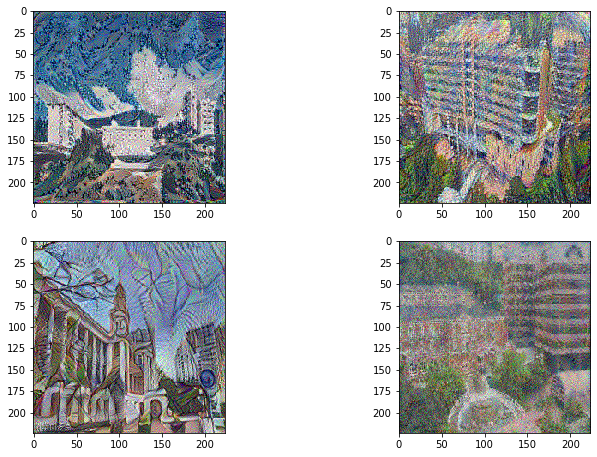

In [9]:
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 3
    
fig.add_subplot(rows, columns, 1)
plt.imshow(tf.cast(result_tensor[0],tf.int16))
fig.add_subplot(rows, columns, 2)
plt.imshow(tf.cast(result_tensor[1],tf.int16))
fig.add_subplot(rows, columns, 3)
plt.imshow(tf.cast(result_tensor[2],tf.int16))
fig.add_subplot(rows, columns, 4)
plt.imshow(tf.cast(result_tensor[3],tf.int16))
plt.show()

The loss function suggests that the training process has been fully converges and the break down of the total loss facilitates our analysis in the report.

--- 291.85977506637573 seconds ---
Final loss data
Content_loss: tf.Tensor(320723360.0, shape=(), dtype=float32)
Style_loss: tf.Tensor(20551746000.0, shape=(), dtype=float32)
Variation_loss: tf.Tensor(570557.94, shape=(), dtype=float32)
STYLE LOSS BY LAYERS
block1_conv1 tf.Tensor(
[[20139490. ]
 [ 1530434.5]
 [ 2176751. ]
 [ 3462299. ]], shape=(4, 1), dtype=float32)
block2_conv1 tf.Tensor(
[[7.3142598e+08]
 [1.9080829e+08]
 [1.6569458e+08]
 [8.2609616e+07]], shape=(4, 1), dtype=float32)
block3_conv1 tf.Tensor(
[[6.1020531e+08]
 [2.2563520e+08]
 [4.2055674e+08]
 [6.4300440e+07]], shape=(4, 1), dtype=float32)
block4_conv1 tf.Tensor(
[[1.2497271e+10]
 [6.1095905e+09]
 [8.9246525e+09]
 [2.7182372e+09]], shape=(4, 1), dtype=float32)
block5_conv1 tf.Tensor(
[[32895602. ]
 [39051760. ]
 [35504144. ]
 [ 4044677.8]], shape=(4, 1), dtype=float32)


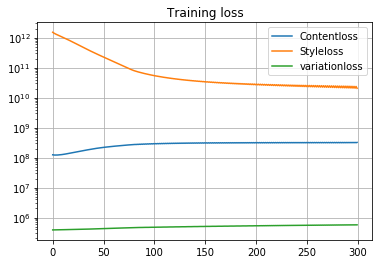

In [10]:
print("--- %s seconds ---" % (time.time() - start_time))
    
print("Final loss data")
print("Content_loss:",CONTENT_LOSS[-1])
print("Style_loss:",STYLE_LOSS[-1])
print("Variation_loss:",VARIATION_LOSS[-1])
    
print("STYLE LOSS BY LAYERS")
for i,name in enumerate(STYLE_LAYERS):
    print(name,STYLE_LOSS_P[i][-1])

fig, ax = plt.subplots()
plt.title("Training loss")
ax.set_yscale('log')
ax.plot(CONTENT_LOSS, label='Contentloss')
ax.plot(STYLE_LOSS, label='Styleloss')
ax.plot(VARIATION_LOSS, label='variationloss')
plt.grid()
plt.legend()
plt.show()